# Encoder Decoder

## Set up

In [1]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import time
import random
# Import PyTorch modules (edit this list if needed)
import torch
print(f'PyTorch version: {torch.__version__}')
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from matplotlib import image as mpimg
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

from dataset_creation.ImageCreation import ImageCreation

PyTorch version: 2.1.0+cu121


In [2]:
device = None
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.empty_cache()
else:
    device = torch.device("cpu")

In [3]:
WIDTH, HEIGHT = 128, 128
STROKE_SIZE = 3
IMAGE_FACTOR = 1.1
EPOCHS: int = 20
BATCH_SIZE: int = 32

In [4]:
resources_folder = 'resources/sketchrnn'

classes = ['apple', 'golf club', 'hedgehog', 'moon', 'mushroom', 'rain', 'roller coaster', 'squirrel']
nb_classes = len(classes)
class_size = {}

data = []

for class_name in classes:
    data_class = np.load(os.path.join(resources_folder, 'sketchrnn_' + class_name + '.npz'), allow_pickle=True, encoding="latin1")

    class_size[class_name] = len(data_class)
    data.append(data_class)

print(f'loaded numpy bitmaps, {nb_classes} classes')
print(len(data))
print(data[0].keys())
print(len(data[0]['train']))
print(len(data[0]['valid']))
print(len(data[0]['test']))

loaded numpy bitmaps, 8 classes
8
KeysView(NpzFile 'resources/sketchrnn/sketchrnn_apple.npz' with keys: test, train, valid)
70000
2500
2500


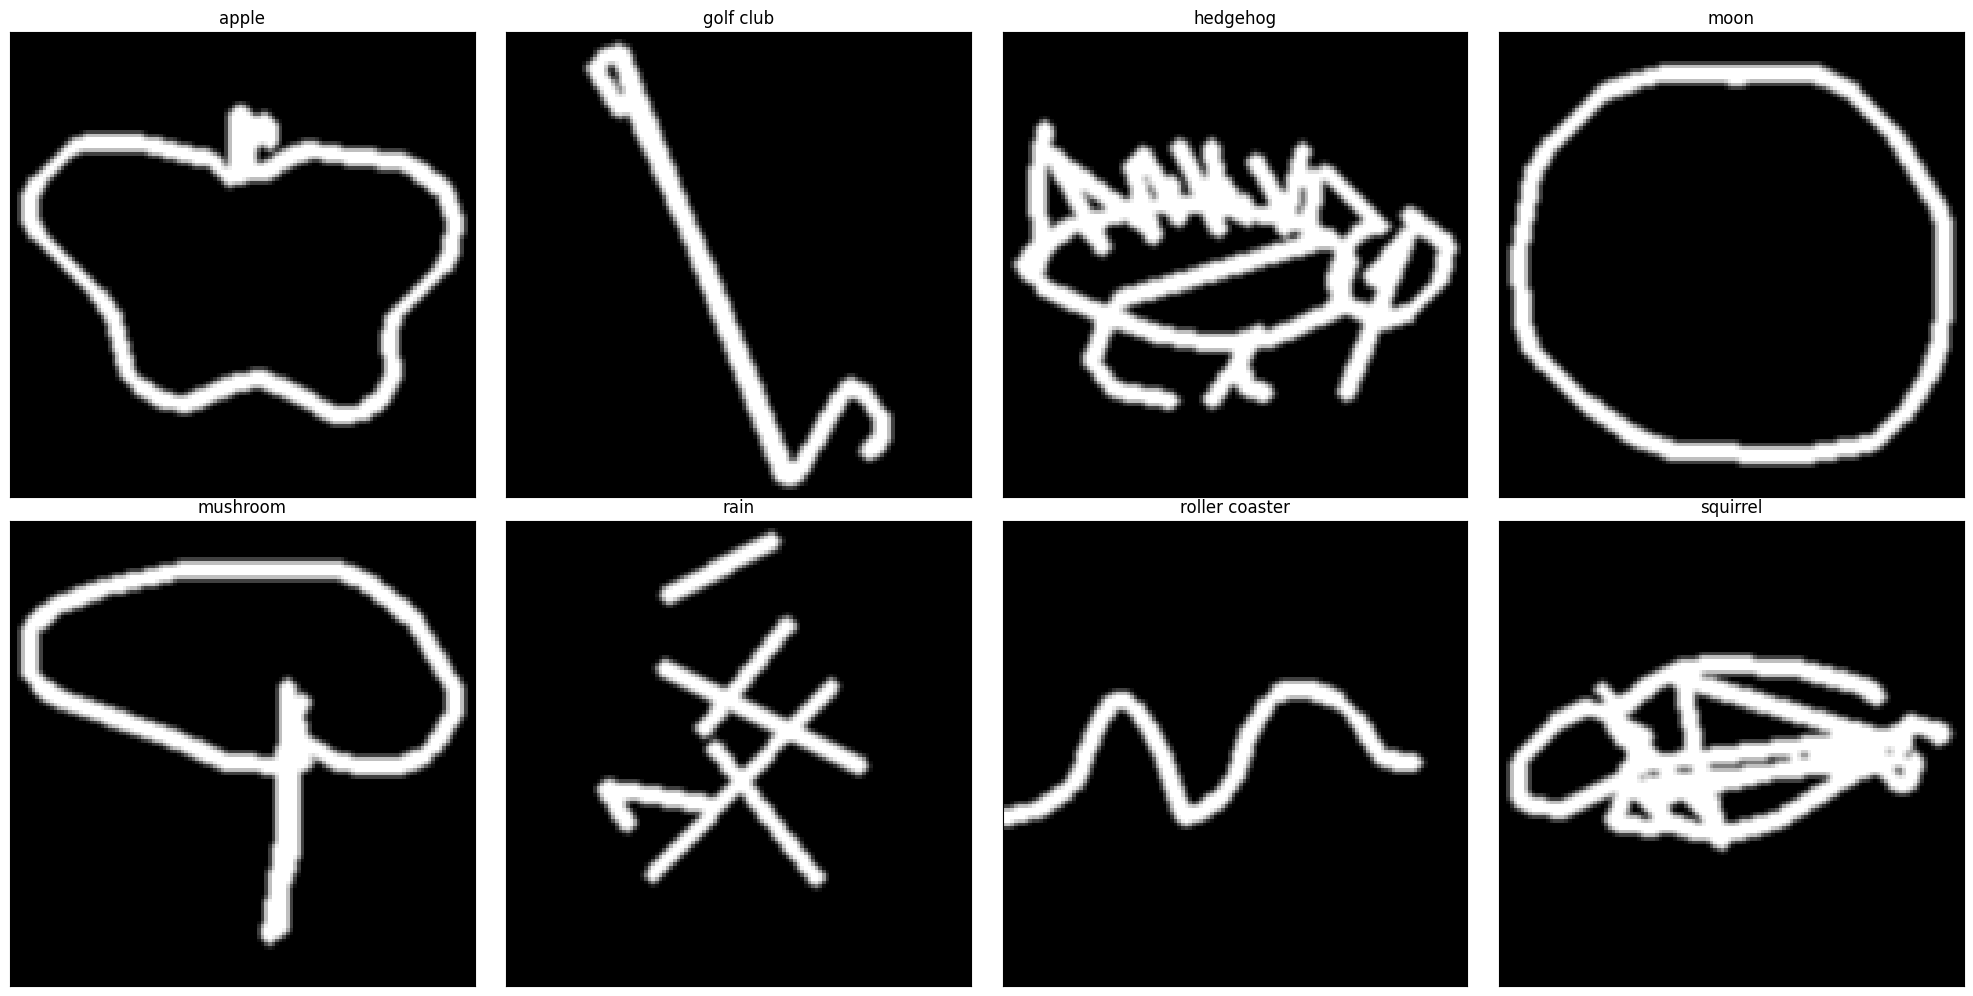

In [5]:
numb_rows = 2
numb_cols = 4

fig, axes = plt.subplots(numb_rows, numb_cols, figsize=(5*numb_cols, 5*numb_rows))
for i in range(nb_classes):
    index = random.randint(0, class_size[classes[i]])
    ax = axes[i//numb_cols, i%numb_cols]
    ax.imshow(ImageCreation.createImage(data[i]["train"][index], (WIDTH, HEIGHT), STROKE_SIZE, IMAGE_FACTOR), cmap='gray')
    ax.set_title(classes[i])

    # no ticks
    ax.set_xticks([])
    ax.set_yticks([])


plt.tight_layout()
plt.show()

## Dataset creation

In [6]:
from dataset_creation.DataManagerNpz import DataManagerNpz

data_manager = DataManagerNpz()

training_data, training_labels, validation_data, validation_labels, test_data, test_labels = data_manager.parse_data(data)

print(f'training dataset size : {len(training_data)}')
print(f'validation dataset size : {len(validation_data)}')
print(f'test dataset size : {len(test_data)}') 

training dataset size : 560000
validation dataset size : 20000
test dataset size : 20000


In [7]:
shuffled_training_data, shuffled_training_labels = data_manager.shuffle_dataset(training_data, training_labels)

shuffled_validation_data, shuffled_validation_labels = data_manager.shuffle_dataset(validation_data, validation_labels)

shuffled_test_data, shuffled_test_labels = data_manager.shuffle_dataset(test_data, test_labels)

print(type(training_labels))
print(type(shuffled_training_data))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [8]:
from dataset_creation.StrokeImageDataset import StrokeImageDataset

len_subset = 30
valid_test_subset = 10

training_set = StrokeImageDataset(
        data=shuffled_training_data[:len_subset], 
        labels=shuffled_training_labels[:len_subset],
        width=WIDTH, height=HEIGHT, 
        stroke_size=STROKE_SIZE, factor=IMAGE_FACTOR, 
        reshape=False, normalize=True)

validation_set = StrokeImageDataset(
        data=shuffled_validation_data[:valid_test_subset], 
        labels=shuffled_validation_labels[:valid_test_subset],
        width=WIDTH, height=HEIGHT, 
        stroke_size=STROKE_SIZE, factor=IMAGE_FACTOR, 
        reshape=False, normalize=True)

test_set = StrokeImageDataset(
        data=shuffled_test_data[:valid_test_subset], 
        labels=shuffled_test_labels[:valid_test_subset],
        width=WIDTH, height=HEIGHT, 
        stroke_size=STROKE_SIZE, factor=IMAGE_FACTOR, 
        reshape=False, normalize=True)

training_loaded_set = DataLoader(training_set, batch_size=BATCH_SIZE, shuffle=True)
validation_loaded_set = DataLoader(validation_set, batch_size=BATCH_SIZE , shuffle=True)
test_loaded_set = DataLoader(test_set, batch_size=BATCH_SIZE , shuffle=True)

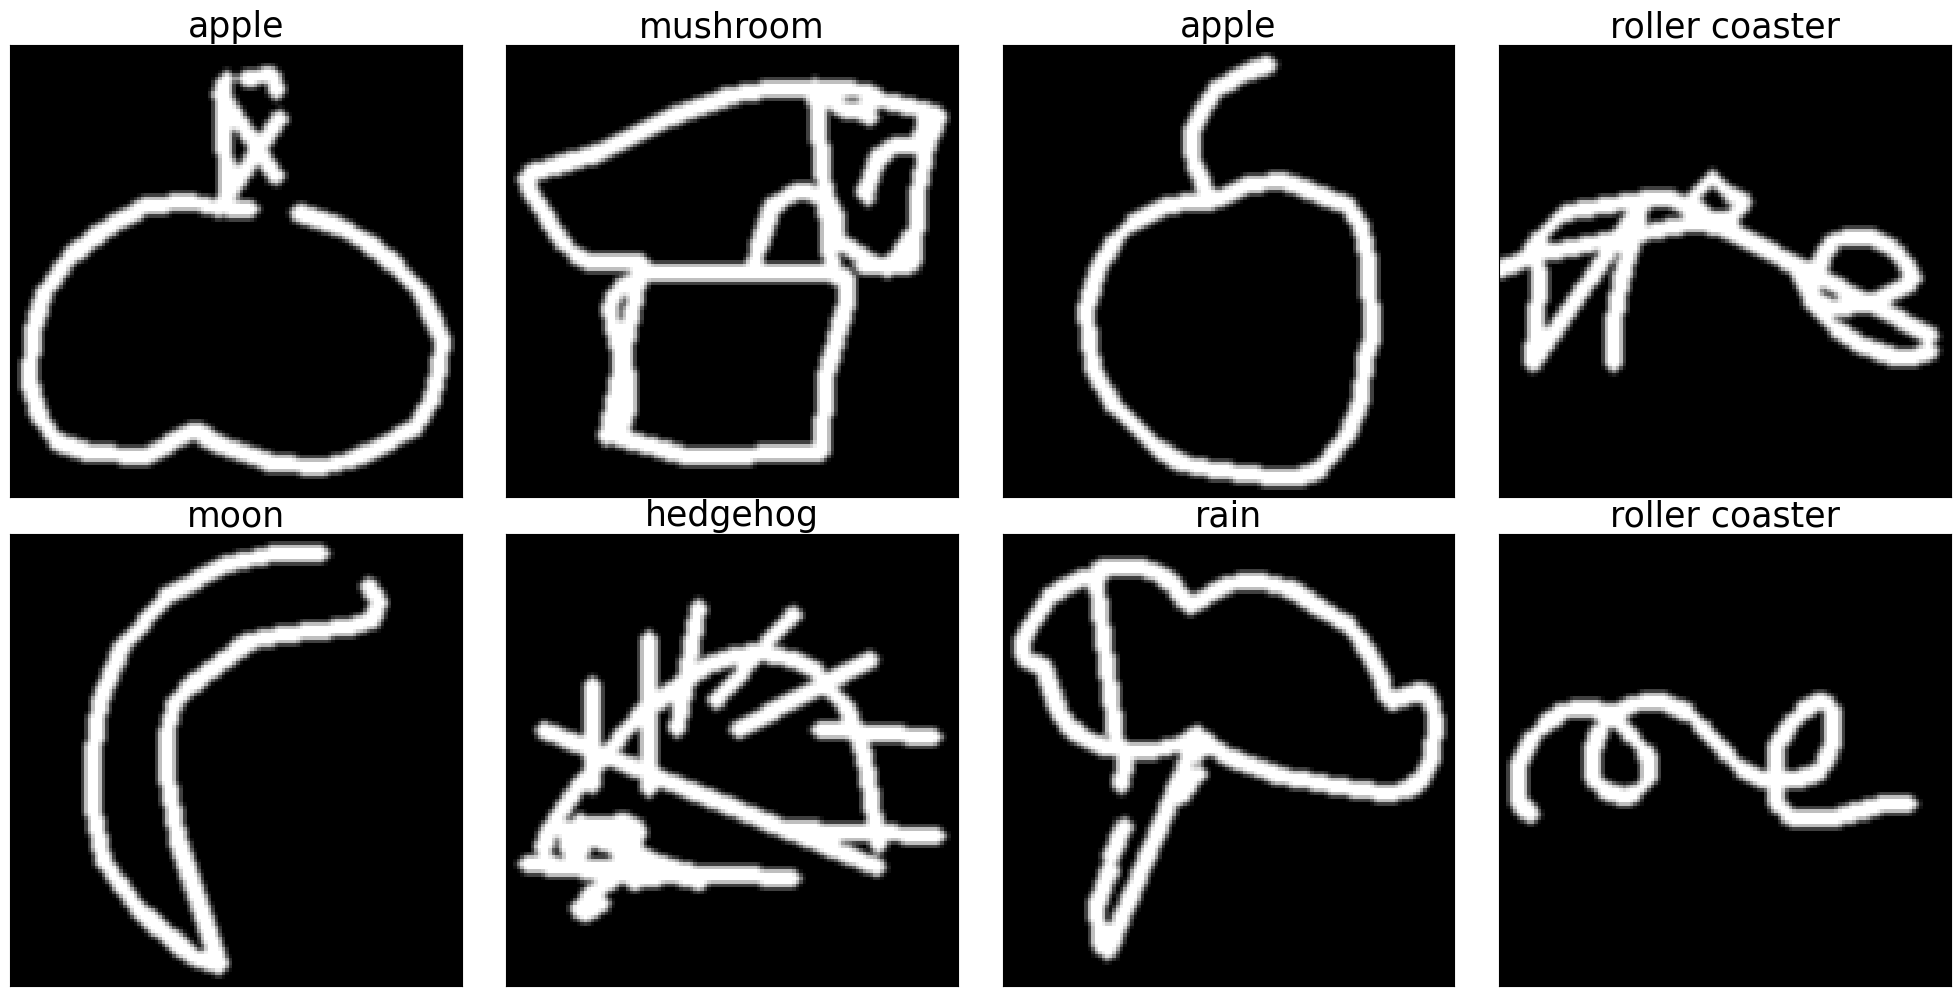

In [9]:
# Show some images
numb_rows = 2
numb_cols = 4

fig, axes = plt.subplots(numb_rows, numb_cols, figsize=(5*numb_cols, 5*numb_rows))
for i in range(numb_rows*numb_cols):
    index = random.randint(0, len(training_set))
    ax = axes[i//numb_cols, i%numb_cols]

    img, label_index = training_set[index]

    ax.imshow(training_set.convert_to_img(img), cmap='gray')
    ax.set_title(classes[label_index], fontsize=25)

    # no ticks
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()

## Autoencoder class

In [10]:
class Autoencoder(nn.Module):
    def __init__(self, layer_sizes=[WIDTH * HEIGHT, 128, 64, 32]):
        super(Autoencoder, self).__init__()
        self.architecture = layer_sizes
        self.encoder = nn.Sequential()
        self.decoder = nn.Sequential()

        # Add encoder layers
        for i in range(len(layer_sizes) - 1):
            self.encoder.add_module(f"encoder_{i}", nn.Linear(layer_sizes[i], layer_sizes[i+1]))
            if i < len(layer_sizes) - 2:
                self.encoder.add_module(f"encoder_relu_{i}", nn.ReLU())
                self.encoder.add_module(f"encoder_dropout_{i}", nn.Dropout(0.3))
                self.encoder.add_module(f"encoder_batchnorm_{i}", nn.BatchNorm1d(layer_sizes[i+1]))

        # Add decoder layers
        for i in range(len(layer_sizes) - 1, 0, -1):
            self.decoder.add_module(f"decoder_{i}", nn.Linear(layer_sizes[i], layer_sizes[i-1]))
            if i > 1:
                self.decoder.add_module(f"decoder_relu_{i}", nn.ReLU())
                self.decoder.add_module(f"encoder_dropout_{i}", nn.Dropout(0.3))
                self.decoder.add_module(f"encoder_batchnorm_{i}", nn.BatchNorm1d(layer_sizes[i+1]))

        self.decoder.add_module("decoder_sigmoid", nn.Sigmoid())

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        
        return encoded, decoded

    def print_model(self):
        print(self.encoder)
        print(self.decoder)

## Try with simple model

In [11]:
architecture_1 = [WIDTH * HEIGHT, WIDTH * HEIGHT // 3]
autoencoder_model = Autoencoder(architecture_1).to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder_model.parameters(), lr=0.1)

In [12]:
# Print architecture 
autoencoder_model.print_model()

# Compression factor 
print(f'Compression factor: {WIDTH * HEIGHT / architecture_1[-1]}')

Sequential(
  (encoder_0): Linear(in_features=16384, out_features=5461, bias=True)
)
Sequential(
  (decoder_1): Linear(in_features=5461, out_features=16384, bias=True)
  (decoder_sigmoid): Sigmoid()
)
Compression factor: 3.000183116645303


In [13]:
def tensor_to_numpy(tensor):
    return tensor.cpu().detach().numpy()

def tensor_to_img(tensor):
    return tensor_to_numpy(tensor).reshape((WIDTH, HEIGHT))

In [14]:
def train_autoencoder(autoencoder_model, train_loader: DataLoader, valid_loader: DataLoader, criterion, optimizer, num_epochs):
    train_psnr_values = []
    train_ssim_values = []

    validation_psnr_values = []
    validation_ssim_values = []

    train_loss_values = []
    validation_loss_values = []

    autoencoder_model.train()

    for epoch in range(num_epochs):
        # Train by batch of images
        for data in train_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            _, decoded = autoencoder_model.forward(inputs)
            loss = criterion(input=decoded, target=inputs)

            # Backward pass
            loss.backward()
            optimizer.step()

        # Train loss
        train_loss_values.append(loss.item())

        # loop on validation to compute validation loss
        for data in valid_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            
            # Forward pass
            _, decoded = autoencoder_model.forward(inputs)
            loss = criterion(input=decoded, target=inputs)

        validation_loss_values.append(loss.item())

        # Calculate PSNR and SSIM for train and test sets
        train_psnr = 0
        train_ssim = 0
        validation_psnr = 0
        validation_ssim = 0

        nb_train_images = 0
        nb_valid_images = 0
        
        for data in train_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            
            for i in range(inputs.size(0)):
                nb_train_images+=1
                img_as_tensor = inputs[i]

                _, decoded = autoencoder_model(img_as_tensor)

                image_matrix = tensor_to_numpy(img_as_tensor)
                decoded_matrix = tensor_to_numpy(decoded)

                train_psnr += psnr(image_matrix, decoded_matrix)
                train_ssim += ssim(image_matrix, decoded_matrix, data_range=decoded_matrix.max() - decoded_matrix.min())

        for data in valid_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            
            for i in range(inputs.size(0)):
                nb_valid_images+=1
                img_as_tensor = inputs[i]

                _, decoded = autoencoder_model(img_as_tensor)

                image_matrix = tensor_to_numpy(img_as_tensor)
                decoded_matrix = tensor_to_numpy(decoded)

                validation_psnr += psnr(image_matrix, decoded_matrix)
                validation_ssim += ssim(image_matrix, decoded_matrix, data_range=decoded_matrix.max() - decoded_matrix.min())

        train_psnr /= nb_train_images
        train_ssim /= nb_train_images
        validation_psnr /= nb_valid_images
        validation_ssim /= nb_valid_images

        train_psnr_values.append(train_psnr)
        train_ssim_values.append(train_ssim)
        validation_psnr_values.append(validation_psnr)
        validation_ssim_values.append(validation_ssim)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss_values[-1]:.4f}, Valid Loss {validation_loss_values[-1]:.4f}, ', end = "")
        print(f'Train PSNR: {train_psnr:.4f}, Train SSIM: {train_ssim:.4f}, Validation PSNR: {validation_psnr:.4f}, Validation SSIM: {validation_ssim:.4f}')

    autoencoder_model.eval()

    return train_loss_values, validation_loss_values, train_psnr_values, train_ssim_values, validation_psnr_values, validation_ssim_values

In [15]:
# Call the function
num_epochs = 40
train_loss_values, validation_loss_values, train_psnr_values, train_ssim_values, validation_psnr_values, validation_ssim_values \
    = train_autoencoder(autoencoder_model, training_loaded_set, validation_loaded_set, criterion, optimizer, num_epochs)

Epoch [1/40], Loss: 0.2303, Valid Loss 0.8340, Train PSNR: 0.7751, Train SSIM: 0.0294, Validation PSNR: 0.8026, Validation SSIM: 0.0409
Epoch [2/40], Loss: 0.8383, Valid Loss 0.8339, Train PSNR: 0.7752, Train SSIM: 0.0294, Validation PSNR: 0.8028, Validation SSIM: 0.0408
Epoch [3/40], Loss: 0.8382, Valid Loss 0.8340, Train PSNR: 0.7753, Train SSIM: 0.0294, Validation PSNR: 0.8026, Validation SSIM: 0.0408
Epoch [4/40], Loss: 0.8382, Valid Loss 0.8340, Train PSNR: 0.7753, Train SSIM: 0.0294, Validation PSNR: 0.8025, Validation SSIM: 0.0408
Epoch [5/40], Loss: 0.8382, Valid Loss 0.8340, Train PSNR: 0.7753, Train SSIM: 0.0294, Validation PSNR: 0.8025, Validation SSIM: 0.0408
Epoch [6/40], Loss: 0.8382, Valid Loss 0.8340, Train PSNR: 0.7754, Train SSIM: 0.0294, Validation PSNR: 0.8026, Validation SSIM: 0.0408
Epoch [7/40], Loss: 0.8382, Valid Loss 0.8340, Train PSNR: 0.7754, Train SSIM: 0.0294, Validation PSNR: 0.8026, Validation SSIM: 0.0408
Epoch [8/40], Loss: 0.8382, Valid Loss 0.8340, T

In [16]:
# Define a function to plot Train and Test Loss, PSNR and SSIM values
def plot_psnr_ssim(train_loss_values, test_loss_values, train_psnr_values, test_psnr_values, train_ssim_values, test_ssim_values):
    _, axes = plt.subplots(1, 3, figsize=(12, 6))

    axes[0].plot(train_loss_values, label='Train Loss')
    axes[0].plot(test_loss_values, label='Validation Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()

    axes[1].plot(train_psnr_values, label='Train PSNR')
    axes[1].plot(test_psnr_values, label='Validation PSNR')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('PSNR')
    axes[1].legend()

    axes[2].plot(train_ssim_values, label='Train SSIM')
    axes[2].plot(test_ssim_values, label='Validation SSIM')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('SSIM')
    axes[2].legend()

    plt.tight_layout()
    plt.show()


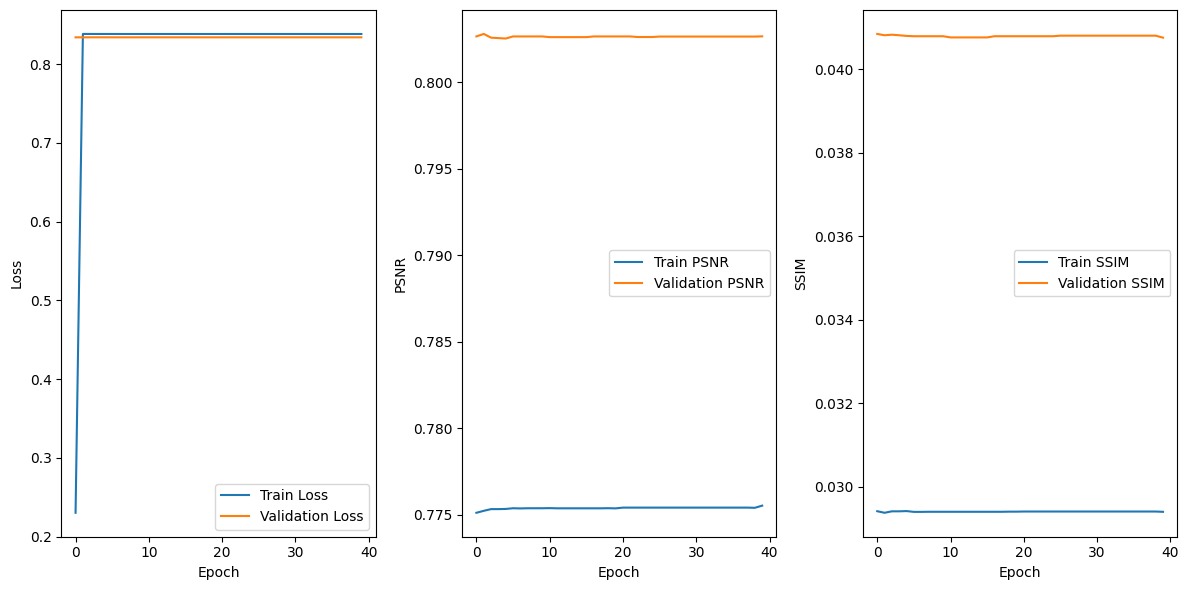

In [17]:
# Call the function
plot_psnr_ssim(train_loss_values, validation_loss_values, train_psnr_values, validation_psnr_values, train_ssim_values, validation_ssim_values)

In [18]:
# Define a function to show original and reconstructed images
def show_images(train_set, validation_set, autoencoder_model):
    num_cols = 4
    num_rows = 2

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 6))

    for i in range(num_cols // 2):
        # Train images
        index = random.randint(0, train_set.__len__())

        axes[0, i].imshow(train_set.get_image_2d(index), cmap='gray')
        axes[0, i].set_title(f"Train original {train_set[index][1]}")
        axes[0, i].axis('off')

        # Reconstructed images
        train_tensor = torch.from_numpy(train_set[index][0]).to(device)
        encoded, decoded = autoencoder_model(train_tensor)
        decoded = decoded.view(-1, HEIGHT, WIDTH)  # Reshape decoded images

        axes[1, i].imshow(decoded.cpu().detach().numpy()[0], cmap='gray')
        axes[1, i].set_title(f"Train reconstructed {classes[train_set[index][1]]}")
        axes[1, i].axis('off')
    
    for i in range(num_cols // 2, num_cols):
        # Test images
        index = random.randint(0, validation_set.__len__())

        axes[0, i].imshow(validation_set.get_image_2d(index), cmap='gray')
        axes[0, i].set_title(f"Validation original, {validation_set[index][1]}")
        axes[0, i].axis('off')

        # Reconstructed images
        validation_tensor = torch.from_numpy(validation_set[index][0]).to(device)
        encoded, decoded = autoencoder_model(validation_tensor)
        decoded = decoded.view(-1, HEIGHT, WIDTH)

        axes[1, i].imshow(decoded.cpu().detach().numpy()[0], cmap='gray')
        axes[1, i].set_title(f"Validation reconstructed {classes[validation_set[index][1]]}")
        axes[1, i].axis('off')

    plt.show()

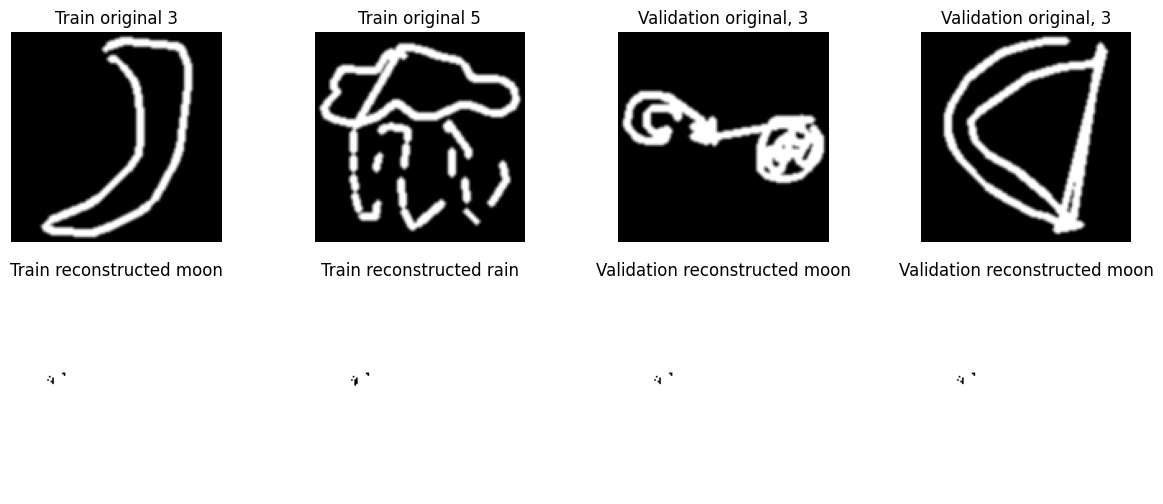

In [19]:
# Call the function
show_images(training_set, validation_set, autoencoder_model)

In [20]:
# Show image with the lowest psnr then ssim in the test set
def return_lowest_image_index_psnr_ssim(dataset, autoencoder_model):
    lowest_psnr = 100
    lowest_ssim = 100
    lowest_psnr_index = 0
    lowest_ssim_index = 0

    for batch in dataset:
        test_images, test_labels = batch
        test_images, test_labels = test_images.to(device), test_labels.to(device)

        _, decoded = autoencoder_model(test_images)

        decoded_matrices = decoded.cpu().detach().numpy()
        test_images_matrices = test_images.cpu().detach().numpy()

        for i in range(test_images.size(0)):
            image_matrix = test_images_matrices[i]
            decoded_matrix = decoded_matrices[i]

            psnr_value = psnr(image_matrix, decoded_matrix)
            ssim_value = ssim(image_matrix, decoded_matrix, data_range=decoded_matrix.max() - decoded_matrix.min())
            
            if psnr_value < lowest_psnr:
                lowest_psnr = psnr_value
                lowest_psnr_index = i

            if ssim_value < lowest_ssim:
                lowest_ssim = ssim_value
                lowest_ssim_index = i

    return [lowest_psnr_index, lowest_psnr], [lowest_ssim_index, lowest_ssim]

In [21]:
CHECK_BACTH_SIZE = 8000

training_check_dataloader= DataLoader(training_set, batch_size=CHECK_BACTH_SIZE, shuffle=False)
validation_check_dataloader = DataLoader(validation_set, batch_size=CHECK_BACTH_SIZE, shuffle=False)

In [22]:
lowest_psnr, lowest_ssim = return_lowest_image_index_psnr_ssim(validation_check_dataloader, autoencoder_model)
print(f'Lowest PSNR index: {lowest_psnr[0]}|{lowest_psnr[1]}, Lowest SSIM index: {lowest_ssim[0]}|{lowest_ssim[1]}')

Lowest PSNR index: 0|0.4916097447068667, Lowest SSIM index: 3|0.020105962205497072


In [23]:
# Show image with the lowest psnr and ssim compared to their original the test set on same plot
def show_lowest_psnr_ssim_image(image_set, autoencoder_model, lowest_psnr, lowest_ssim):
    lowest_psnr_index, psnr  = lowest_psnr
    psnr_image_label = classes[image_set[lowest_psnr_index][1]]

    lowest_ssim_index, ssim  = lowest_ssim
    ssim_image_label = classes[image_set[lowest_ssim_index][1]]

    fig, axes = plt.subplots(2, 2, figsize=(7, 6))

    # PSNR image
    axes[0, 0].imshow(image_set.get_image_2d(lowest_psnr_index), cmap='gray')
    axes[0, 0].set_title("Original : " + psnr_image_label)
    axes[0, 0].axis('off')

    psnr_image_tensor = torch.from_numpy(image_set[lowest_psnr_index][0]).to(device)
    _, decoded = autoencoder_model(psnr_image_tensor)
    decoded = decoded.view(-1, HEIGHT, WIDTH)  # Reshape decoded images

    axes[0, 1].imshow(decoded.cpu().detach().numpy()[0], cmap='gray')
    axes[0, 1].set_title(f"Reconstructed : {psnr_image_label}, PSNR: {psnr:.4f}")
    axes[0, 1].axis('off')

    # SSIM image
    axes[1, 0].imshow(image_set.get_image_2d(lowest_ssim_index), cmap='gray')
    axes[1, 0].set_title("Original : " + ssim_image_label)
    axes[1, 0].axis('off')

    ssim_image_tensor = torch.from_numpy(image_set[lowest_ssim_index][0]).to(device)
    _, decoded = autoencoder_model(ssim_image_tensor)
    decoded = decoded.view(-1, HEIGHT, WIDTH)  # Reshape decoded images

    axes[1, 1].imshow(decoded.cpu().detach().numpy()[0], cmap='gray')
    axes[1, 1].set_title(f"Reconstructed : {ssim_image_label}, SSIM: {ssim:.4f}")
    axes[1, 1].axis('off')

    plt.show()


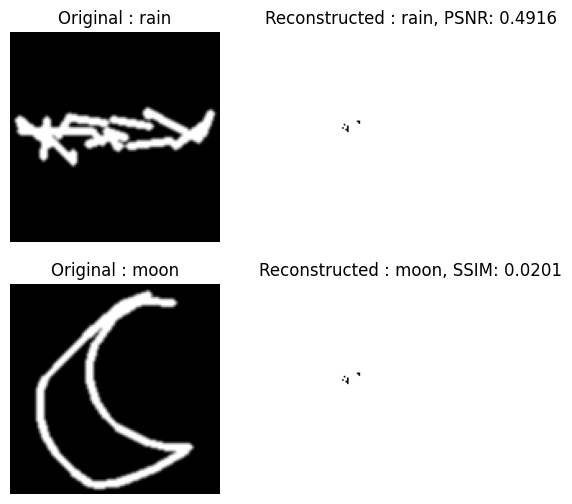

In [24]:
# Call the function
show_lowest_psnr_ssim_image(validation_set, autoencoder_model, lowest_psnr, lowest_ssim)

## Try with a different model architecture

In [25]:
layers = [WIDTH * HEIGHT, WIDTH * HEIGHT]
autocoder_2 = Autoencoder(layers).to(device)

# Define loss function and optimizer

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autocoder_2.parameters(), lr=0.001)

# Print architecture
autocoder_2.print_model()

# Compression factor
print(f'Compression factor: {WIDTH * HEIGHT / autocoder_2.architecture[-1]}')

Sequential(
  (encoder_0): Linear(in_features=16384, out_features=16384, bias=True)
)
Sequential(
  (decoder_1): Linear(in_features=16384, out_features=16384, bias=True)
  (decoder_sigmoid): Sigmoid()
)
Compression factor: 1.0


In [26]:
# Call the function
num_epochs = 40

train_loss_values, validation_loss_values, train_psnr_values, train_ssim_values, validation_psnr_values, validation_ssim_values \
    = train_autoencoder(autocoder_2, training_loaded_set, validation_loaded_set, criterion, optimizer, num_epochs)

Epoch [1/40], Loss: 0.2302, Valid Loss 0.1752, Train PSNR: 8.5460, Train SSIM: 0.0388, Validation PSNR: 7.6009, Validation SSIM: 0.0043
Epoch [2/40], Loss: 0.1404, Valid Loss 0.1449, Train PSNR: 8.8979, Train SSIM: 0.5481, Validation PSNR: 8.5390, Validation SSIM: 0.5424
Epoch [3/40], Loss: 0.1319, Valid Loss 0.1549, Train PSNR: 8.5653, Train SSIM: 0.5579, Validation PSNR: 8.2407, Validation SSIM: 0.5586
Epoch [4/40], Loss: 0.1427, Valid Loss 0.1445, Train PSNR: 8.8818, Train SSIM: 0.6191, Validation PSNR: 8.5960, Validation SSIM: 0.6220
Epoch [5/40], Loss: 0.1338, Valid Loss 0.1412, Train PSNR: 8.9678, Train SSIM: 0.6408, Validation PSNR: 8.7116, Validation SSIM: 0.6472
Epoch [6/40], Loss: 0.1315, Valid Loss 0.1393, Train PSNR: 9.0256, Train SSIM: 0.6513, Validation PSNR: 8.7841, Validation SSIM: 0.6585
Epoch [7/40], Loss: 0.1300, Valid Loss 0.1381, Train PSNR: 9.0601, Train SSIM: 0.6577, Validation PSNR: 8.8326, Validation SSIM: 0.6659
Epoch [8/40], Loss: 0.1291, Valid Loss 0.1374, T

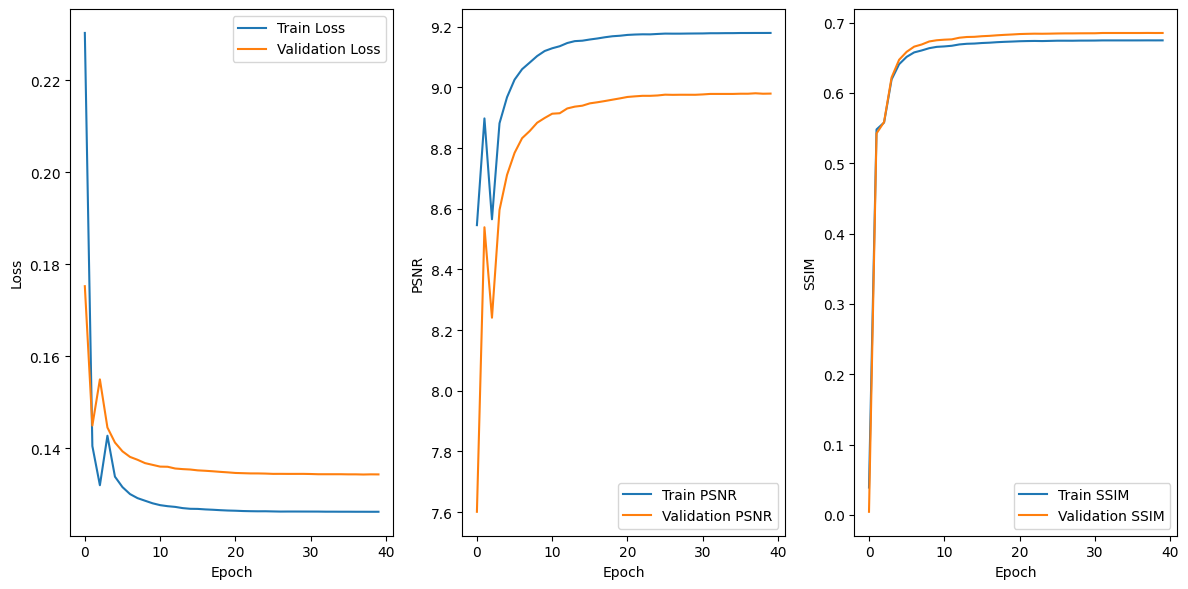

In [27]:
plot_psnr_ssim(train_loss_values, validation_loss_values, train_psnr_values, validation_psnr_values, train_ssim_values, validation_ssim_values)

AssertionError: 

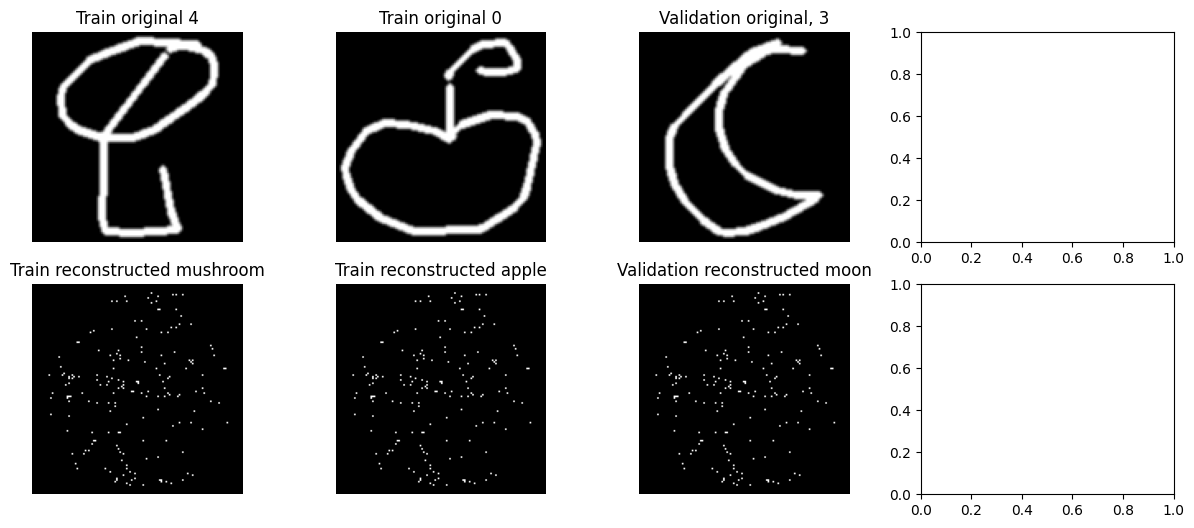

In [28]:
show_images(training_set, validation_set, autocoder_2)

Lowest PSNR index: 3|6.364516687164324, Lowest SSIM index: 4|0.6174975888652247


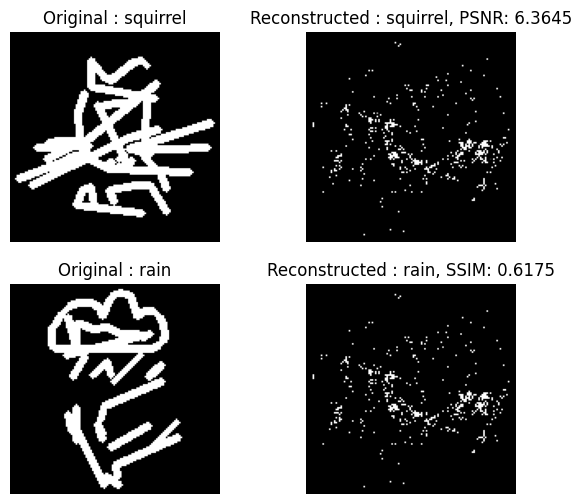

In [ ]:
lowest_psnr, lowest_ssim = return_lowest_image_index_psnr_ssim(validation_check_dataloader, autocoder_2)
print(f'Lowest PSNR index: {lowest_psnr[0]}|{lowest_psnr[1]}, Lowest SSIM index: {lowest_ssim[0]}|{lowest_ssim[1]}')

show_lowest_psnr_ssim_image(validation_set, autocoder_2, lowest_psnr, lowest_ssim)

## Try with resnet18 architecture

In [ ]:
# Use pretrained model

# Load pretrained model

pretrained_model = models.resnet18(pretrained=True)
pretrained_model = pretrained_model.to(device)

# Print pretrained model architecture
print(pretrained_model)

# Freeze all layers

for param in pretrained_model.parameters():
    param.requires_grad = False

# Add custom layers

pretrained_model.fc = nn.Sequential(
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, nb_classes)
)

# Print new model architecture
print(pretrained_model)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(pretrained_model.fc.parameters(), lr=0.001)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

/home/mabazin/miniconda3/envs/tf/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mabazin/miniconda3/envs/tf/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Define a function to train the model
def train_pretained_model():
    pass

## Generating images

In [ ]:
def return_classes_mean_encoded_vector(model, images_set):
    mean_encoded_vectors = []
    mean_vectors_size = model.architecture[-1]
    count_classes_number = [0] * nb_classes

    for i in range(nb_classes):
        mean_encoded_vectors.append(np.zeros(mean_vectors_size))

    for batch in images_set:
        images, labels = batch
        images, labels = images.to(device), labels.to(device)

        encoded, decoded = model(images)
        encoded_np = encoded.cpu().detach().numpy()

        for i in range(len(images)):
            mean_encoded_vectors[labels[i]] += encoded_np[i]

        count_classes_number[labels[i]] += 1
            
    for i in range(nb_classes):
        mean_encoded_vectors[i] = mean_encoded_vectors[i] / count_classes_number[i] / 255.0

        print(f'Class {classes[i]} range of mean encoded vector: [{mean_encoded_vectors[i].min()}, {mean_encoded_vectors[i].max()}]')

    return mean_encoded_vectors

def generated_images_for_mean_vector(mean_encoded_vectors, model):
    generated_images = []

    decoder = model.decoder
    for i in range(nb_classes):
        mean_vector = mean_encoded_vectors[i]
        double_mean_vector = np.array([mean_vector]).astype(np.float32)
        mean_vector_torch = torch.from_numpy(double_mean_vector).to(device)

        decoded = decoder(mean_vector_torch)

        generated_images.append(decoded.cpu().detach().numpy()[0].reshape(HEIGHT, WIDTH))

    return generated_images

def show_generated_images(generated_images):
    num_cols = 4
    num_rows = 2

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 6))

    for i in range(nb_classes):
        row_index = i // num_cols
        col_index = i % num_cols
        axes[row_index, col_index].imshow(generated_images[i], cmap='gray')
        axes[row_index, col_index].axis('off')
        axes[row_index, col_index].set_title(classes[i])

    plt.tight_layout()
    plt.suptitle('Generated images')

    plt.subplots_adjust(top=0.9)

    plt.show()

In [ ]:
def create_alternative_version(mean_vector, weight=0.1):
    alternative_mean_vector = mean_vector.copy()
    # Vector is composed of float values 
    # use gaussian distribution to generate altertivate vector based on mean one

    for i in range(len(mean_vector)):
        alternative_mean_vector[i] = np.random.normal(mean_vector[i], weight)
    
    return alternative_mean_vector

/tmp/ipykernel_43766/846146186.py:22: RuntimeWarning: divide by zero encountered in divide
  mean_encoded_vectors[i] = mean_encoded_vectors[i] / count_classes_number[i] / 255.0
/tmp/ipykernel_43766/846146186.py:22: RuntimeWarning: invalid value encountered in divide
  mean_encoded_vectors[i] = mean_encoded_vectors[i] / count_classes_number[i] / 255.0


Class apple range of mean encoded vector: [-inf, inf]
Class golf club range of mean encoded vector: [nan, nan]
Class hedgehog range of mean encoded vector: [-inf, inf]
Class moon range of mean encoded vector: [-inf, inf]
Class mushroom range of mean encoded vector: [-inf, inf]
Class rain range of mean encoded vector: [nan, nan]
Class roller coaster range of mean encoded vector: [-0.267744322384105, 0.26397499383664597]
Class squirrel range of mean encoded vector: [-inf, inf]


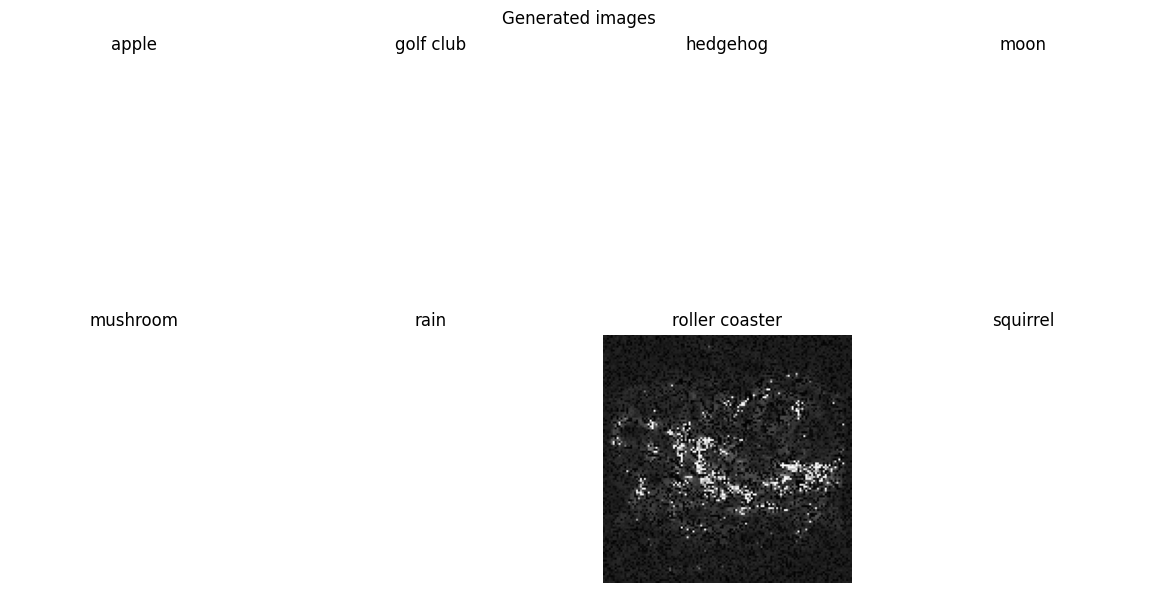

In [ ]:
mean_encoded_vectors = return_classes_mean_encoded_vector(autoencoder_model, training_loaded_set)
generated_images = generated_images_for_mean_vector(mean_encoded_vectors, autoencoder_model)
show_generated_images(generated_images)

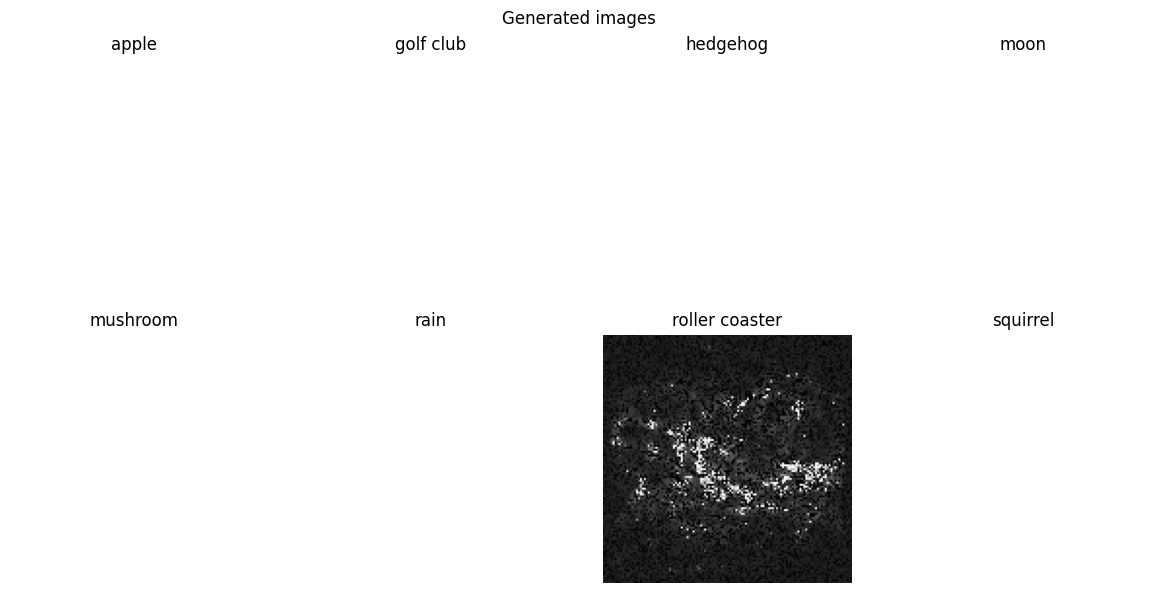

In [ ]:
alternative_versions = []
for mean_encoded_vector in mean_encoded_vectors:
    alternative_versions.append(create_alternative_version(mean_encoded_vector, 0.05))

alternative_generated_version = generated_images_for_mean_vector(alternative_versions, autoencoder_model)
show_generated_images(alternative_generated_version)

/tmp/ipykernel_43766/846146186.py:22: RuntimeWarning: divide by zero encountered in divide
  mean_encoded_vectors[i] = mean_encoded_vectors[i] / count_classes_number[i] / 255.0
/tmp/ipykernel_43766/846146186.py:22: RuntimeWarning: invalid value encountered in divide
  mean_encoded_vectors[i] = mean_encoded_vectors[i] / count_classes_number[i] / 255.0


Class apple range of mean encoded vector: [-inf, inf]
Class golf club range of mean encoded vector: [nan, nan]
Class hedgehog range of mean encoded vector: [-inf, inf]
Class moon range of mean encoded vector: [-inf, inf]
Class mushroom range of mean encoded vector: [-inf, inf]
Class rain range of mean encoded vector: [nan, nan]
Class roller coaster range of mean encoded vector: [-0.267744322384105, 0.26397499383664597]
Class squirrel range of mean encoded vector: [-inf, inf]


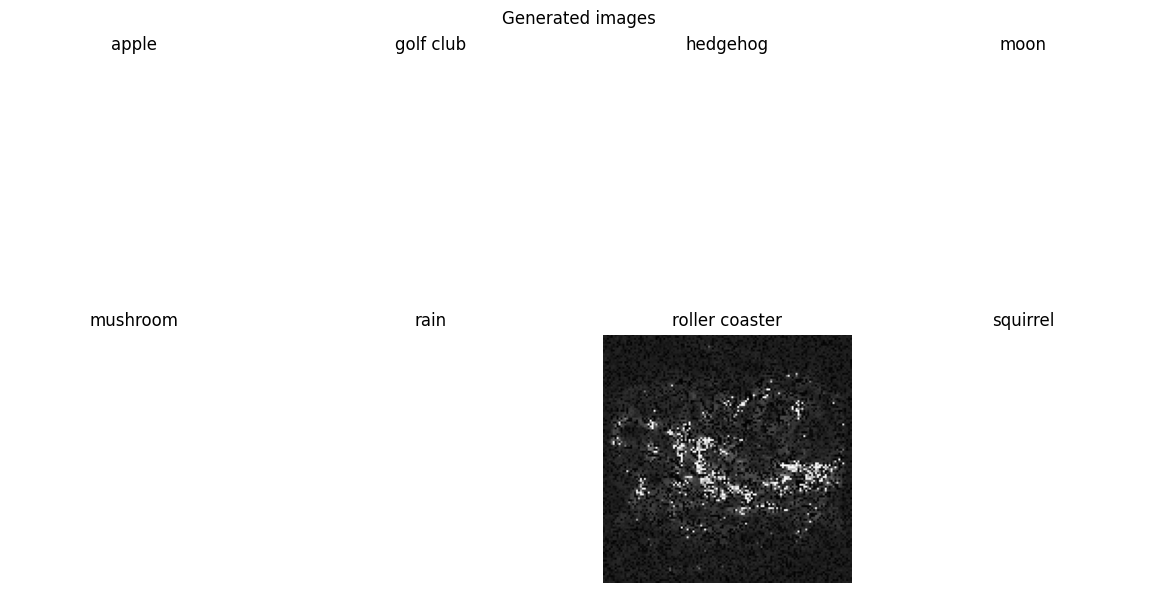

In [ ]:
mean_encoded_vectors = return_classes_mean_encoded_vector(autoencoder_model, training_loaded_set)
generated_images = generated_images_for_mean_vector(mean_encoded_vectors, autoencoder_model)
show_generated_images(generated_images)

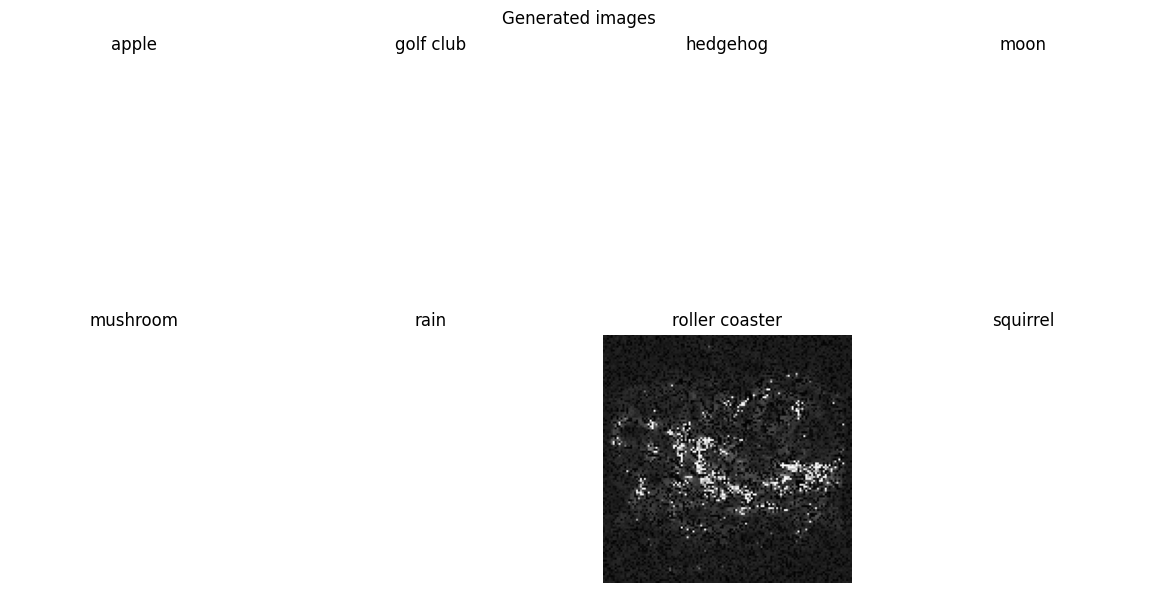

In [ ]:
alternative_versions = []
for mean_encoded_vector in mean_encoded_vectors:
    alternative_versions.append(create_alternative_version(mean_encoded_vector, 0.05))

alternative_generated_version = generated_images_for_mean_vector(alternative_versions, autoencoder_model)
show_generated_images(alternative_generated_version)